/var/folders/ss/8jmv74q91hx88tdtr0hdx12c0000gn/T/ipykernel_94989/2887640250.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  omega2s[count] = pert.sigma2()


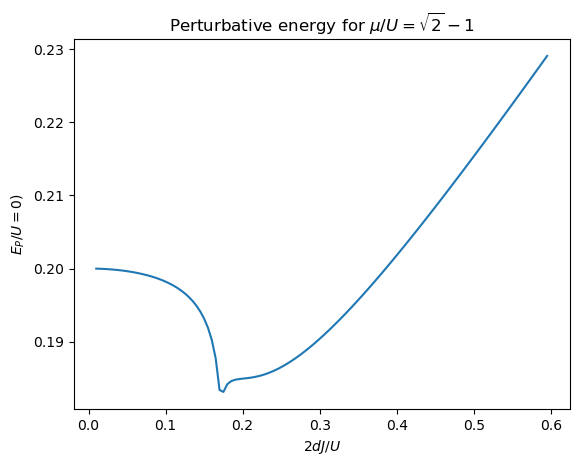

In [3]:
import numpy as np
import os
import utils
from grid import Grid
from params import Params
from gs import groundstate
from exc import excitations
from vert import vertices
from pert import perturbative
from plotting import plot2D, plot_cns, plot_omega0
import matplotlib.pyplot as plt

config_path = "config.yml" 

output_dir = utils.create_output_dir()

config = utils.read_config(config_path)

Lx = config["grid"]["Lx"]
Ly = config["grid"]["Ly"]

N = config["physics"]["N"]
dJUs = np.arange(**config["lists"]["dJUs"])
muU = eval(config["physics"]["muU"])
UIB = config["physics"]["UIB"]
cutoff = config["physics"]["cutoff"]

grid = Grid(Lx, Ly)

omega0s = np.zeros(len(dJUs))
omega1s = np.zeros(len(dJUs))
omega2s = np.zeros(len(dJUs))
omegas = np.zeros((len(dJUs), 3))
for count in range(len(dJUs)):
    dJU = dJUs[count]
    params = Params(N, dJU, muU, UIB, cutoff)
    # print(params.muU)
    gs = groundstate(params)
    cns = gs.cns()
    n0 = gs.n0(cns)
    # print(n0)
    exc = excitations(grid, params, gs, cns)
    uks, vks, omegaklambda = exc.calculate_matrices()
    verts = vertices(grid, gs, uks, vks, cns, n0)
    pert = perturbative(grid, params, verts, omegaklambda)
    omega0s[count] = pert.sigma0(n0)
    omega1s[count] = pert.sigma1()
    omega2s[count] = pert.sigma2()
    # print(omega0s[count], omega1s[count], omega2s[count])
#     omega0s[count] = omegaklambda[1][5][5]
#     omega1s[count] = omegaklambda[2][5][5]
#     omega2s[count] = omegaklambda[3][5][5]
# omegas[:, 0] = omega0s
# omegas[:, 1] = omega1s
# omegas[:, 2] = omega2s
# plot_omega0(
#     omegas,
#     r"$2\delta J/U$",
#     r"$\omega_{\lambda}(|\vec{k}| = 0)$", show=True
# )
plt.plot(dJUs, omega0s + omega1s + omega2s, label=r"$\omega_{0}$")
plt.xlabel(r"$2d J/U$")
plt.ylabel(r"$E_P/U = 0)$")
plt.title(r"Perturbative energy for $\mu/U = \sqrt{2}-1$")
plt.show()
# plt.plot(dJUs, omega1s, label=r"$\omega_{0}$")
# plt.show()



In [4]:
# Write a code that calculates muU for a given sigma0

muU_qcorr = np.zeros(len(dJUs))
dJUmax = (np.sqrt(2) - 1)**2
print(dJUmax)
# start with large values of dJU and decrease it 
for count in range(len(dJUs)):
    dJU = dJUs[count]
    found = False
    muU = 0.4
    if(dJU < dJUmax):
        muU = np.sqrt(2) - 1
    else:
        muU = muU - 0.2
        while((muU < 0.5) and (not found)): # change muU until 1 - pert.sigma0(n0) / UIB = 0
            params = Params(N, dJU, muU, UIB, cutoff)
            gs = groundstate(params)
            cns = gs.cns()
            n0 = gs.n0(cns)
            exc = excitations(grid, params, gs, cns)
            uks, vks, omegaklambda = exc.calculate_matrices()
            verts = vertices(grid, gs, uks, vks, cns, n0)
            pert = perturbative(grid, params, verts, omegaklambda)
            eq = pert.sigma0(n0) / UIB
            # print(muU,eq)
            if(1 - eq < 0.0001):
                found = True
                break
            muU += 0.0001
    
    muU_qcorr[count] = muU
    # print("dJU = ", dJU, "muU = ", muU_qcorr[count])

plt.plot(dJUs, muU_qcorr, label=r"$\omega_{0}$")
plt.show()



0.17157287525381
0.2 0.9233338051831081
0.2001 0.9234359680852136
0.2002 0.9235380504919329
0.20029999999999998 0.9236400524171513
0.20039999999999997 0.9237419738747716
0.20049999999999996 0.9238438148787079
0.20059999999999995 0.9239455754428957
0.20069999999999993 0.9240472555812896
0.20079999999999992 0.924148855307854
0.2008999999999999 0.9242503746365782
0.2009999999999999 0.9243518135814494
0.2010999999999999 0.9244531721565025
0.20119999999999988 0.9245544503757587
0.20129999999999987 0.9246556482532786
0.20139999999999986 0.9247567658031228


KeyboardInterrupt: 

In [39]:
print(dJUs, muU_qcorr)

[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42
 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56
 0.57 0.58 0.59] [0.41421356 0.41421356 0.41421356 0.41421356 0.41421356 0.41421356
 0.41421356 0.41421356 0.41421356 0.41421356 0.41421356 0.41421356
 0.41421356 0.41421356 0.41421356 0.41421356 0.41421356 0.419
 0.415      0.412      0.407      0.403      0.399      0.394
 0.39       0.385      0.38       0.375      0.37       0.365
 0.36       0.354      0.35       0.35       0.35       0.35
 0.35       0.35       0.35       0.35       0.35       0.35
 0.35       0.35       0.35       0.35       0.35       0.35
 0.35       0.35       0.35       0.35       0.35       0.35
 0.35       0.35       0.35       0.35       0.35      ]


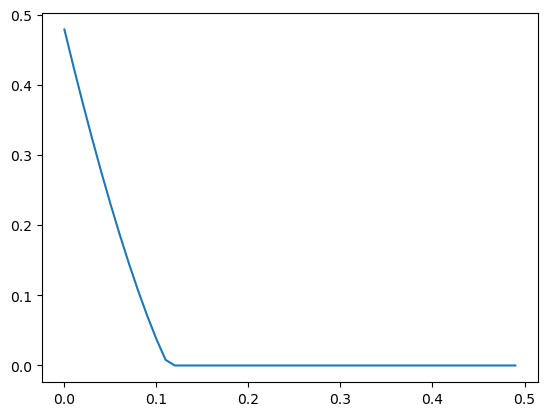

In [32]:
# Write a code that calculates muU for a given sigma0
muU = 0.5
muU_qcorr = np.zeros(len(dJUs))
# start with large values of dJU and decrease it 
for count in range(8, 9):
    dJU = dJUs[count]
    found = False
    muU = muU + 0.01
    muUs = np.arange(0., 0.5, 0.01)
    eqs = np.zeros(len(muUs))
    for u in range(len(muUs)):
        muU = muUs[u]
        params = Params(N, dJU, muU, UIB, cutoff)
        # print(params.muU)
        gs = groundstate(params)
        cns = gs.cns()
        n0 = gs.n0(cns)
        exc = excitations(grid, params, gs, cns)
        uks, vks, omegaklambda = exc.calculate_matrices()
        verts = vertices(grid, gs, uks, vks, cns, n0)
        pert = perturbative(grid, params, verts, omegaklambda)
        eq = pert.sigma0(n0) / UIB
        eqs[u] = eq

plt.plot(muUs, 1 - eqs, label=r"$\omega_{0}$")


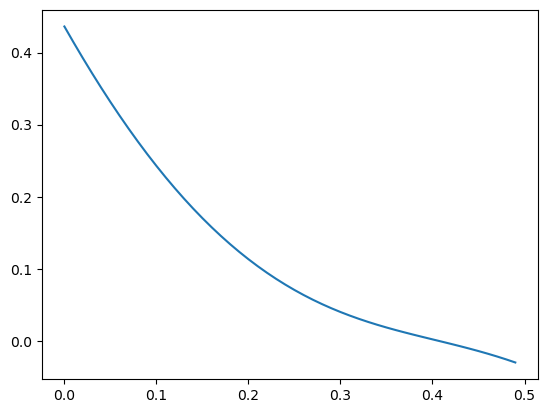

In [25]:
plt.plot(muUs, 1 - eqs, label=r"$\omega_{0}$")